<a href="https://colab.research.google.com/github/LauraPrieto0124/Colombia_EKC_estimation/blob/main/Ln_mean_NTL_col_ESDA_in_phyton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analisys (ESDA) for ln(meanNTL) concentration in Colombia between 2016 - 2022




# Setup

In [1]:
# Adding necessary libraries to Google Colab environment

# Installing the 'contextily' library for adding basemaps to plots
!pip install contextily -q

# Installing the 'splot' library for spatial data visualization
!pip install splot -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 20.2 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries for data analysis and visualization
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # Importing matplotlib image for image plotting
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Importing libraries for spatial data and visualization
import geopandas as gpd
import folium
from folium import Figure

import contextily as cx

import libpysal
from libpysal  import weights
from libpysal.weights import Queen

# Exploratory Spatial Data Analysis (ESDA) tools
import mapclassify as mc
import esda
from esda.moran import Moran, Moran_Local

# Spatial plotting tools
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights
from splot.mapping import vba_choropleth

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import data

In [3]:
# Define the URL where the GeoJSON data is located
gdf = gpd.read_file("https://raw.githubusercontent.com/LauraPrieto0124/Colombia_EKC_estimation/main/Data/mean_NTL_adm2_col.geojson")

In [4]:
gdf.head(3)

id  ADM0_CODE ADM0_NAME  ADM1_CODE ADM1_NAME  \
0  20160101_00020000000000001bf9         57  Colombia        934  Amazonas   
1  20160101_00020000000000001bfa         57  Colombia        934  Amazonas   
2  20160101_00020000000000001bfb         57  Colombia        934  Amazonas   

   ADM2_CODE    ADM2_NAME DISP_AREA  EXP2_YEAR        STATUS  STR2_YEAR  \
0      13333   El Encanto        NO       3000  Member State       1000   
1      13334  La Chorrera        NO       3000  Member State       1000   
2      13335   La Pedrera        NO       3000  Member State       1000   

   Shape_Area  Shape_Leng  mean  year  \
0    0.880307    7.970986   0.0  2016   
1    1.806759    7.253629   0.0  2016   
2    1.961139    9.741906   0.0  2016   

                                            geometry  
0  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...  
1  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...  
2  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...

In [ ]:
gdf["ID"] = (
    gdf["ADM1_NAME"].str.replace(" ", "_") + "_" + gdf["ADM2_NAME"].str.replace(" ", "_")
)
gdf_2021 = gdf[gdf["year"] == 2021]
gdf_2021.head(3)

id  ADM0_CODE ADM0_NAME  ADM1_CODE ADM1_NAME  \
5430  20210101_00020000000000001bf9         57  Colombia        934  Amazonas   
5431  20210101_00020000000000001bfa         57  Colombia        934  Amazonas   
5432  20210101_00020000000000001bfb         57  Colombia        934  Amazonas   

      ADM2_CODE    ADM2_NAME DISP_AREA  EXP2_YEAR        STATUS  STR2_YEAR  \
5430      13333   El Encanto        NO       3000  Member State       1000   
5431      13334  La Chorrera        NO       3000  Member State       1000   
5432      13335   La Pedrera        NO       3000  Member State       1000   

      Shape_Area  Shape_Leng      mean  year  \
5430    0.880307    7.970986  0.000000  2021   
5431    1.806759    7.253629  0.000000  2021   
5432    1.961139    9.741906  0.000027  2021   

                                               geometry                    ID  
5430  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...   Amazonas_El_Encanto  
5431  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...  Amazonas_La_Chorrera  
5432  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...   Amazonas_La_Pedrera

In [ ]:
gdf['mean'] = np.where(gdf['mean'] < 0, 0, gdf['mean'])

In [ ]:
LOG_OFFSET_1 = 0.1
scaling_factor = 1000
gdf["ln_meanNTL"] = np.log(scaling_factor*(LOG_OFFSET_1 + gdf["mean"]))


In [ ]:
gdf = pd.pivot(gdf, index=['ADM1_NAME', 'ADM2_NAME', "geometry", "ID"], columns='year', values='ln_meanNTL')
gdf.columns.name = None
gdf.reset_index(inplace=True)
gdf.head(3)

ADM1_NAME    ADM2_NAME                                           geometry  \
0  Amazonas   El Encanto  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...   
1  Amazonas  La Chorrera  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...   
2  Amazonas   La Pedrera  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...   

                     ID     2016     2017      2018      2019     2020  \
0   Amazonas_El_Encanto  4.60517  4.60517  4.605170  4.605170  4.60517   
1  Amazonas_La_Chorrera  4.60517  4.60517  4.605170  4.605170  4.60517   
2   Amazonas_La_Pedrera  4.60517  4.60528  4.605431  4.605291  4.60517   

       2021  
0  4.605170  
1  4.605170  
2  4.605439

In [ ]:
gdf.columns = gdf.columns.astype(str)

In [ ]:
print(gdf['2021'].isna().sum())  # Ver cuántos NaN hay
print(gdf['2021'].nunique())

0
1036


In [ ]:
new_column_names = {
    '2016': 'ln_meanNTL_2016',
    '2017': 'ln_meanNTL_2017',
    '2018': 'ln_meanNTL_2018',
    "2019": "ln_meanNTL_2019",
    "2020": "ln_meanNTL_2020",
    "2021": "ln_meanNTL_2021",
}

gdf = gdf.rename(columns=new_column_names)

gdf.head(3)

ADM1_NAME    ADM2_NAME                                           geometry  \
0  Amazonas   El Encanto  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...   
1  Amazonas  La Chorrera  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...   
2  Amazonas   La Pedrera  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...   

                     ID  ln_meanNTL_2016  ln_meanNTL_2017  ln_meanNTL_2018  \
0   Amazonas_El_Encanto          4.60517          4.60517         4.605170   
1  Amazonas_La_Chorrera          4.60517          4.60517         4.605170   
2   Amazonas_La_Pedrera          4.60517          4.60528         4.605431   

   ln_meanNTL_2019  ln_meanNTL_2020  ln_meanNTL_2021  
0         4.605170          4.60517         4.605170  
1         4.605170          4.60517         4.605170  
2         4.605291          4.60517         4.605439

In [ ]:
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

In [ ]:
gdf_geometry = gpd.read_file("/content/drive/MyDrive/Earthengine/BBDD/GeoJSON_MP25_2016_2022.geojson")
gdf_geometry.head(3)

ADM2_CODE ADM0_CODE ADM0_NAME ADM1_CODE ADM1_NAME    ADM2_NAME  \
0     13333        57  Colombia       934  Amazonas   El Encanto   
1     13334        57  Colombia       934  Amazonas  La Chorrera   
2     13335        57  Colombia       934  Amazonas   La Pedrera   

       Shape_Area     Shape_Leng                2016               2017  \
0  0.880306810873  7.97098609968   6.494019413204314  6.711721903995237   
1   1.80675895017  7.25362865525  6.5365655156367986  6.367585836246434   
2    1.9611389611  9.74190609128   6.496319499240682  5.966264320189016   

                 2018               2019               2020  \
0  7.0351896409950845  5.855572552064537  5.556749286952656   
1   6.602226578203584  5.703246918755068  5.262504594029465   
2   6.052429848444638  5.503512765174166  4.977001429599789   

                2021               2022                    ID  \
0  5.461822924508663  6.828982349850428   Amazonas_El Encanto   
1  5.156294115412039  6.337690607087084  Amazonas_La Chorrera   
2  4.797858966888844  5.760720153076429   Amazonas_La Pedrera   

                                            geometry  
0  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...  
1  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...  
2  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...

In [ ]:
gdf_geometry.columns = gdf_geometry.columns.astype(str)

In [ ]:
gdf_geometry["ID"] = (
    gdf_geometry["ADM1_NAME"].str.replace(" ", "_") + "_" + gdf_geometry["ADM2_NAME"].str.replace(" ", "_")
)
gdf_geometry.head(3)

ADM2_CODE ADM0_CODE ADM0_NAME ADM1_CODE ADM1_NAME    ADM2_NAME  \
0     13333        57  Colombia       934  Amazonas   El Encanto   
1     13334        57  Colombia       934  Amazonas  La Chorrera   
2     13335        57  Colombia       934  Amazonas   La Pedrera   

       Shape_Area     Shape_Leng                2016               2017  \
0  0.880306810873  7.97098609968   6.494019413204314  6.711721903995237   
1   1.80675895017  7.25362865525  6.5365655156367986  6.367585836246434   
2    1.9611389611  9.74190609128   6.496319499240682  5.966264320189016   

                 2018               2019               2020  \
0  7.0351896409950845  5.855572552064537  5.556749286952656   
1   6.602226578203584  5.703246918755068  5.262504594029465   
2   6.052429848444638  5.503512765174166  4.977001429599789   

                2021               2022                    ID  \
0  5.461822924508663  6.828982349850428   Amazonas_El_Encanto   
1  5.156294115412039  6.337690607087084  Amazonas_La_Chorrera   
2  4.797858966888844  5.760720153076429   Amazonas_La_Pedrera   

                                            geometry  
0  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...  
1  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...  
2  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...

In [ ]:
# Verificar si las geometrías son iguales
if gdf.geometry.equals(gdf_geometry.geometry):
    print("The geometry is identical")
else:
    print("The geometry is different")

The geometry is different


In [ ]:
gdf = gdf.merge(gdf_geometry[['geometry', "ID"]], on= ["ID"], how='left')

In [ ]:
gdf.head(10)

ADM1_NAME         ADM2_NAME  \
0   Amazonas        El Encanto   
1   Amazonas       La Chorrera   
2   Amazonas        La Pedrera   
3   Amazonas           Leticia   
4   Amazonas     Miriti Parana   
5   Amazonas     Puerto Narino   
6   Amazonas  Puerto Santander   
7   Amazonas          Tarapaca   
8  Antioquia         Abejorral   
9  Antioquia          Abriaqui   

                                          geometry_x  \
0  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...   
1  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...   
2  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...   
3  POLYGON ((-70.31012 -3.60219, -70.30787 -3.622...   
4  POLYGON ((-69.9508 -1.12962, -69.95305 -1.1318...   
5  POLYGON ((-70.31012 -3.60219, -70.30563 -3.581...   
6  POLYGON ((-72.61651 -0.92301, -72.59855 -0.920...   
7  POLYGON ((-71.82376 -2.18961, -71.82151 -2.187...   
8  POLYGON ((-75.57642 5.71769, -75.56743 5.7132,...   
9  POLYGON ((-76.18502 6.66765, -76.18053 6.64295...   

                          ID  ln_meanNTL_2016  ln_meanNTL_2017  \
0        Amazonas_El_Encanto         4.605170         4.605170   
1       Amazonas_La_Chorrera         4.605170         4.605170   
2        Amazonas_La_Pedrera         4.605170         4.605280   
3           Amazonas_Leticia         4.830645         4.844356   
4     Amazonas_Miriti_Parana         4.605170         4.605170   
5     Amazonas_Puerto_Narino         4.605170         4.605170   
6  Amazonas_Puerto_Santander         4.605170         4.605170   
7          Amazonas_Tarapaca         4.605189         4.605251   
8        Antioquia_Abejorral         5.271631         5.291588   
9         Antioquia_Abriaqui         4.713452         4.740031   

   ln_meanNTL_2018  ln_meanNTL_2019  ln_meanNTL_2020  ln_meanNTL_2021  \
0         4.605170         4.605170         4.605170         4.605170   
1         4.605170         4.605170         4.605170         4.605170   
2         4.605431         4.605291         4.605170         4.605439   
3         4.854724         4.836139         4.863964         4.877719   
4         4.605170         4.605170         4.605170         4.605170   
5         4.608653         4.611366         4.611135         4.616363   
6         4.605170         4.605170         4.605170         4.605170   
7         4.605259         4.605237         4.605305         4.605250   
8         5.235827         5.291430         5.221604         5.107767   
9         4.742729         4.802631         4.769594         4.740628   

                                          geometry_y  
0  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...  
1  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...  
2  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...  
3  POLYGON ((-70.31012 -3.60219, -70.30787 -3.622...  
4  POLYGON ((-69.9508 -1.12962, -69.95305 -1.1318...  
5  POLYGON ((-70.31012 -3.60219, -70.30563 -3.581...  
6  POLYGON ((-72.61651 -0.92301, -72.59855 -0.920...  
7  POLYGON ((-71.82376 -2.18961, -71.82151 -2.187...  
8  POLYGON ((-75.57642 5.71769, -75.56743 5.7132,...  
9  POLYGON ((-76.18502 6.66765, -76.18053 6.64295...

In [ ]:
gdf.drop(columns=['geometry_x'], inplace=True)
gdf.rename(columns={'geometry_y': 'geometry'}, inplace=True)

In [ ]:
# Convert the DataFrame back to a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

In [ ]:
island_names= island_names= ['Turbo (is.)', "Cartagena (dist. Esp.) (i", "Gorgona (is.)", "Monitos (is.)", "Santa Marta (dist. Esp.)(",
               "Tumaco (is.)", "San Andres Y Providencia", "San Onofre (is.)", "Name Unknown", "Santa Catalina", "Santa Catarina", "Guapi (is.)", "Timbiqui (is.)",
               "Bajo Baudo (is.)", "Jurado (is.)", "San Bernardo El Viento (i", "Mosquera (is.)", "Necocli (is.)", 	"Buenaventura (is.)" ]


gdf = gdf[~gdf['ADM2_NAME'].isin(island_names)]

# Plot map

In [ ]:
# Visualize spatial data using the explore() method of a GeoDataFrame
gdf.explore(
    # Specify the column to visualize on the map
    column='ln_meanNTL_2021',
    # Specify2a the attributes to display in the tooltip when hovering over map features
    tooltip=["ADM1_NAME", 'ADM2_NAME', 'ln_meanNTL_2016'],
    # Choose the classification scheme for data visualization
    scheme='NaturalBreaks',
    # Specify the number of classes for classification
    k= 3,
    # Choose the colormap for data visualization
    cmap='coolwarm',
    # Specify whether to display a legend
    legend=True,
    # Choose the basemap tiles provider
    tiles='CartoDB positron',
    # Customize the style of the basemap tiles
    style_kwds=dict(color="gray", weight=0.5),
    # Customize the appearance of the legend
    legend_kwds=dict(colorbar=False)
)

In [ ]:
gdf = gdf.dropna(subset=['ln_meanNTL_2021'])

# Spatial weights and lags

In [ ]:
# Remove rows with invalid geometries (None values) before calculating spatial weights
gdf = gdf[gdf.geometry.notnull()]

In [ ]:
# Create a spatial weight matrix using queen criteria
queen_weights = Queen.from_dataframe(gdf)
# Verify the amount of neighbors
neighbors_count = [len(queen_weights.neighbors[i]) for i in range(queen_weights.n)]
print("Neighbors amount:")
print(f"Max neighbords: {max(neighbors_count)}")
print(f"Min neigbords: {min(neighbors_count)}")
print(f"Neighbors average: {sum(neighbors_count) / len(neighbors_count):.2f}")

Neighbors amount:
Max neighbords: 20
Min neigbords: 1
Neighbors average: 5.99


In [ ]:
# Reproject to use contextily
gdf = gdf.to_crs(epsg=3116)

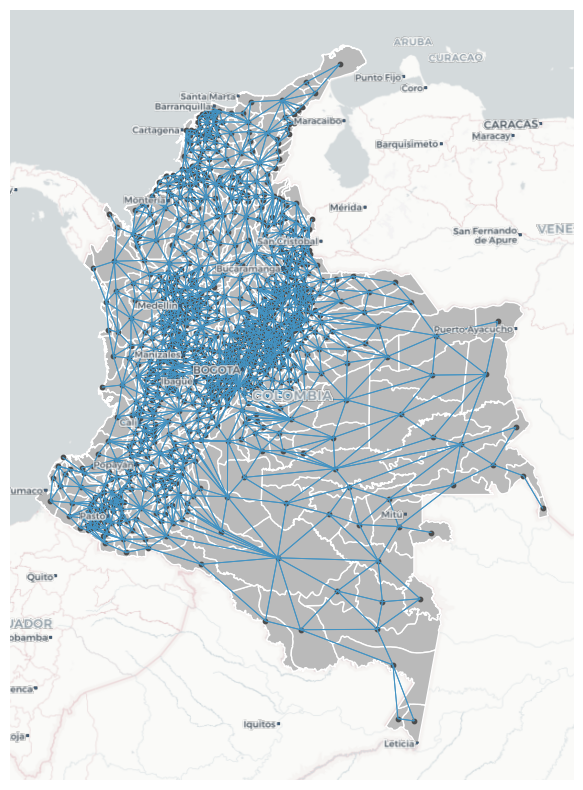

In [ ]:
# Plot the spatial weights using splot library
# This will visualize the spatial relationships between observations defined by the weights matrix W
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,10))
plot_spatial_weights(queen_weights, gdf, ax=ax)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source = cx.providers.CartoDB.Positron,           attribution=False)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source = cx.providers.CartoDB.PositronOnlyLabels, attribution=False)
plt.show()

In [ ]:
#@title Obtaining the k nearest weight matrix
gdf['centroid'] = gdf.geometry.centroid

gdf['lon'] = gdf['centroid'].x
gdf['lat'] = gdf['centroid'].y

coords = gdf[['lon', 'lat']].values

k = 5
weights_KNN = libpysal.weights.KNN(coords, k=k)

In [ ]:
# Reproject to use contextily
gdf = gdf.to_crs(epsg=3116)

# Global spatial dependence

In [ ]:
# Compute Global Moran's I statistic for the 'PM2' variables using the spatial weights matrix W
globalMoran_2016 = Moran(gdf['ln_meanNTL_2016'], weights_KNN)
globalMoran_2017 = Moran(gdf['ln_meanNTL_2017'], weights_KNN)
globalMoran_2018 = Moran(gdf['ln_meanNTL_2018'], weights_KNN)
globalMoran_2019 = Moran(gdf['ln_meanNTL_2019'], weights_KNN)
globalMoran_2020 = Moran(gdf['ln_meanNTL_2020'], weights_KNN)
globalMoran_2021 = Moran(gdf['ln_meanNTL_2021'], weights_KNN)
# Format Moran's I statistic to two decimal places
moranI_2016 = "{:.2f}".format(globalMoran_2016.I)
moranI_2017 = "{:.2f}".format(globalMoran_2017.I)
moranI_2018 = "{:.2f}".format(globalMoran_2018.I)
moranI_2019 = "{:.2f}".format(globalMoran_2019.I)
moranI_2020 = "{:.2f}".format(globalMoran_2020.I)
moranI_2021 = "{:.2f}".format(globalMoran_2021.I)

# Print Moran's I statistic
print(moranI_2016, moranI_2017, moranI_2018, moranI_2019, moranI_2020, moranI_2021)

0.56 0.57 0.57 0.58 0.59 0.60


In [ ]:
print(globalMoran_2016.p_sim)
print(globalMoran_2017.p_sim)
print(globalMoran_2018.p_sim)
print(globalMoran_2019.p_sim)
print(globalMoran_2020.p_sim)
print(globalMoran_2021.p_sim)

0.001
0.001
0.001
0.001
0.001
0.001


In [ ]:
# Calculate spatial lag of PM2.5_2016 using the specified weights
gdf['wimds_2016'] = weights.lag_spatial(weights_KNN, gdf['ln_meanNTL_2016'])
gdf["wimds_2017"] = weights.lag_spatial(weights_KNN, gdf['ln_meanNTL_2017'])
gdf["wimds_2018"] = weights.lag_spatial(weights_KNN, gdf['ln_meanNTL_2018'])
gdf["wimds_2019"] = weights.lag_spatial(weights_KNN, gdf['ln_meanNTL_2019'])
gdf["wimds_2020"] = weights.lag_spatial(weights_KNN, gdf['ln_meanNTL_2020'])
gdf["wimds_2021"] = weights.lag_spatial(weights_KNN, gdf['ln_meanNTL_2021'])

# Local spatial dependence

In [ ]:
# Calculate Local Moran's I statistics
# gdf['PM2.5_2016'] is the variable for which local spatial autocorrelation is computed
# Queen_weights is the spatial weights matrix defining the spatial relationships between observations
# permutations specifies the number of random permutations for statistical inference
# seed sets the seed for reproducibility of random permutations
moranLocal_2016 = Moran_Local(gdf['ln_meanNTL_2016'], weights_KNN, permutations=999, seed=12345)
moranLocal_2017 = Moran_Local(gdf['ln_meanNTL_2017'], weights_KNN, permutations=999, seed=12345)
moranLocal_2018 = Moran_Local(gdf['ln_meanNTL_2018'], weights_KNN, permutations=999, seed=12345)
moranLocal_2019 = Moran_Local(gdf['ln_meanNTL_2019'], weights_KNN, permutations=999, seed=12345)
moranLocal_2020 = Moran_Local(gdf['ln_meanNTL_2020'], weights_KNN, permutations=999, seed=12345)
moranLocal_2021 = Moran_Local(gdf['ln_meanNTL_2021'], weights_KNN, permutations=999, seed=12345)

In [ ]:
gdf['ADM2_NAME'] = gdf['ADM2_NAME'].replace('Santafe De Bogota D.c.', 'Bogota')
gdf['ADM2_NAME'] = gdf['ADM2_NAME'].replace('Cartagena (dist. Esp.)', 'Cartagena')
gdf['ADM2_NAME'] = gdf['ADM2_NAME'].replace('Barranquilla  (dist.port.', 'Barranquilla')

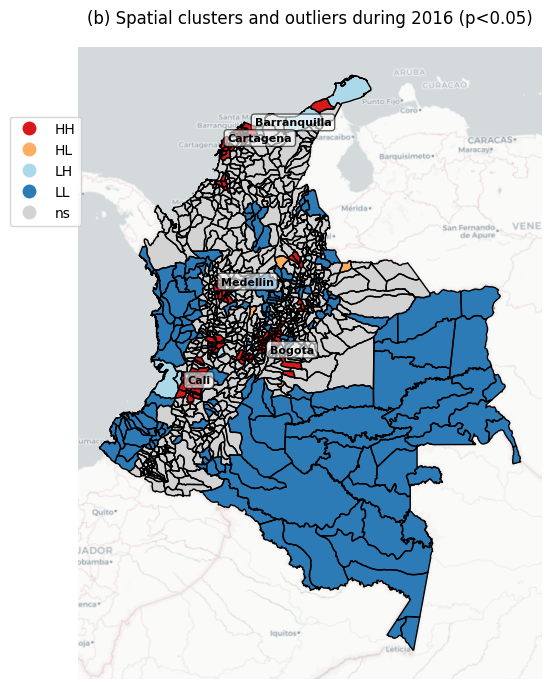

In [ ]:
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2016, gdf, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(b) Spatial clusters and outliers during 2016 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf[gdf['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_NTL_2016.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

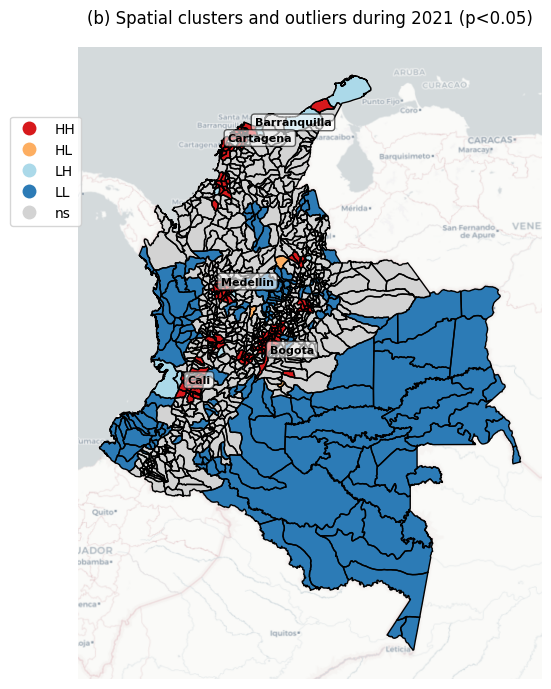

In [ ]:
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2021, gdf, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(b) Spatial clusters and outliers during 2021 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf[gdf['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_NTL_2021.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# Add local Moran's I p-values to the GeoDataFrame
gdf['lisa_2016'] = moranLocal_2016.p_sim
gdf['lisa_2017'] = moranLocal_2017.p_sim
gdf['lisa_2018'] = moranLocal_2018.p_sim
gdf['lisa_2019'] = moranLocal_2019.p_sim
gdf['lisa_2020'] = moranLocal_2020.p_sim
gdf['lisa_2021'] = moranLocal_2021.p_sim

# Classify and assign cluster types based on significance levels
# If p-value is less than 0.05, assign cluster type based on quadrant (q)
gdf.loc[moranLocal_2016.p_sim < 0.05, 'cluster_2016'] = moranLocal_2016.q[moranLocal_2016.p_sim < 0.05]

# Fill NaN values with 0 (for non-significant observations)
gdf["cluster_2016"] = gdf["cluster_2016"].fillna(0)

# Map cluster codes to descriptive labels
gdf["cluster_2016"] = gdf["cluster_2016"].map({
    0: "Not significant",   # No significant spatial autocorrelation
    1: "High-high",         # High value surrounded by high values (hotspot)
    2: "Low-high",          # Low value surrounded by high values
    3: "Low-low",           # Low value surrounded by low values (coldspot)
    4: "High-low",          # High value surrounded by low values
})

In [ ]:
# Create a scatter plot using Plotly Express
fig = px.scatter(
    gdf,
    x='ln_meanNTL_2016',                               # Data for the x-axis
    y= 'wimds_2016',                              # Data for the y-axis
    color='cluster_2016',                        # Color points by cluster type
    color_discrete_sequence=["#4679b1", "#d3d3d3", "#efb16e", "#c23429", "#b5d8e7"],  # Define color sequence for clusters # #c23429 (Red) #4679b1 (Blue), #b5d8e7 (Light blue), #efb16e(Orange), #d3d3d3 (Light grey)
    hover_name='ADM2_NAME',                       # Display municipality name in hover tooltip
    hover_data=['ADM2_NAME', 'cluster_2016', 'ln_meanNTL_2016', 'wimds_2016', 'lisa_2016'],  # Additional data for hover tooltip
    trendline="ols",                        # Add an ordinary least squares (OLS) trendline
    trendline_scope='overall'             # Fit a single trendline for all data points
)

# Set the color of the trendline to black
fig.update_traces(line=dict(color='black'))

# Set the range for x-axis and y-axis
x_range = [min(gdf['ln_meanNTL_2016']), max(gdf['ln_meanNTL_2016'])]
y_range = [min(gdf['wimds_2016']), max(gdf['wimds_2016'])]
fig.update_xaxes(range=x_range)
fig.update_yaxes(range=y_range)

# Add horizontal and vertical lines at the average values
average_imds_value = gdf['ln_meanNTL_2016'].mean()
average_wimds_value = gdf['wimds_2016'].mean()

fig.add_shape(
    type="line",
    x0=average_imds_value,
    y0=y_range[0],
    x1=average_imds_value,
    y1=y_range[1],
    line=dict(color="grey", width=1, dash="dash")
)

fig.add_shape(
    type="line",
    x0=x_range[0],
    y0=average_wimds_value,
    x1=x_range[1],
    y1=average_wimds_value,
    line=dict(color="grey", width=1, dash="dash")
)

# Update layout to set plot background color to white
fig.update_layout(plot_bgcolor='#f9f9f7')

# Display the updated figure
fig.show()

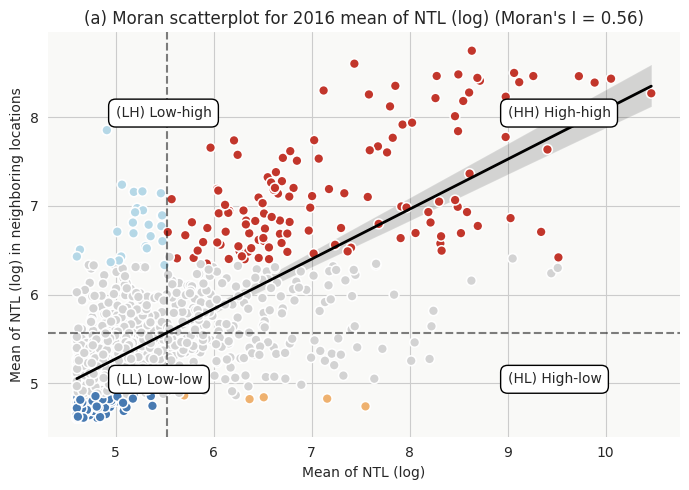

In [ ]:
# Set Seaborn theme to white grid for cleaner appearance
sns.set_style('whitegrid')

# Adjust the aspect ratio for better readability
f, ax = plt.subplots(1, figsize=(7, 5))

# Add the regression line with all grey points
sns.regplot(
    x='ln_meanNTL_2016',
    y='wimds_2016',
    data=gdf,
    scatter=True,
    marker='.',
    color='#d3d3d3',                    # Light gray for points
    line_kws={'linewidth': 2, 'color': 'black'}  # Black for regression line
)

# Overlay the significant points
sns.scatterplot(
    x='ln_meanNTL_2016',
    y="wimds_2016",
    hue="cluster_2016",
    palette= ["#4679b1", "#d3d3d3" , "#b5d8e7", "#c23429", "#efb16e"],  # #c23429 (Red) #4679b1 (Blue), #b5d8e7 (Light blue), #efb16e(Orange), #d3d3d3 (Light grey)
    data=gdf,
    marker=".",
    s=200,  # Increase the marker size here
    alpha=0.99,  # No need for scatter_kws here
    legend=False  # Add this line to remove the legend
)

# Remove spines for a cleaner look
sns.despine(top=True, bottom=True, left=True, right=True)

# Add reference lines (average values)
plt.axvline(gdf['ln_meanNTL_2016'].mean(), c='black', alpha=0.5, linestyle='--')
plt.axhline(gdf['wimds_2016'].mean(), c='black', alpha=0.5, linestyle='--')

# Annotate quadrants directly for clarity
ax.annotate('(HH) High-high', xy=(9, 8), xytext=(9, 8), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(HL) High-low', xy=(9, 5), xytext=(9, 5), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LH) Low-high', xy=(5, 8), xytext=(5, 8), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LL) Low-low', xy=(5, 5), xytext=(5, 5), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))

# Add a title for context
ax.set_title(f"(a) Moran scatterplot for 2016 mean of NTL (log) (Moran's I = {moranI_2016})")

# Create more informative labels
ax.set_xlabel('Mean of NTL (log)')                # Replace with the actual variable name
ax.set_ylabel('Mean of NTL (log) in neighboring locations')   # Replace if applicable

# Set background color for the plot
ax.set_facecolor('#f9f9f7')

# Save and show the plot
plt.tight_layout()
plt.savefig('lisaSC.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Classify and assign cluster types based on significance levels
# If p-value is less than 0.05, assign cluster type based on quadrant (q)
gdf.loc[moranLocal_2021.p_sim < 0.05, 'cluster_2021'] = moranLocal_2021.q[moranLocal_2021.p_sim < 0.05]

# Fill NaN values with 0 (for non-significant observations)
gdf["cluster_2021"] = gdf["cluster_2021"].fillna(0)

# Map cluster codes to descriptive labels
gdf["cluster_2021"] = gdf["cluster_2021"].map({
    0: "Not significant",   # No significant spatial autocorrelation
    1: "High-high",         # High value surrounded by high values (hotspot)
    2: "Low-high",          # Low value surrounded by high values
    3: "Low-low",           # Low value surrounded by low values (coldspot)
    4: "High-low",          # High value surrounded by low values
})

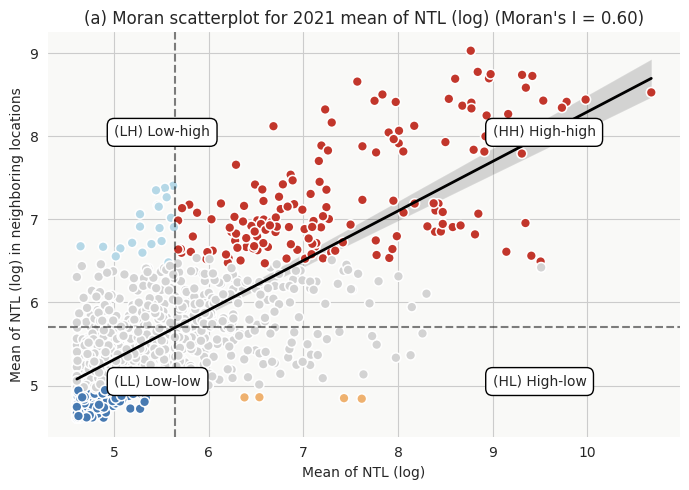

In [ ]:
# Set Seaborn theme to white grid for cleaner appearance
sns.set_style('whitegrid')

# Adjust the aspect ratio for better readability
f, ax = plt.subplots(1, figsize=(7, 5))

# Add the regression line with all grey points
sns.regplot(
    x='ln_meanNTL_2021',
    y='wimds_2021',
    data=gdf,
    scatter=True,
    marker='.',
    color='#d3d3d3',                    # Light gray for points
    line_kws={'linewidth': 2, 'color': 'black'}  # Black for regression line
)

# Overlay the significant points
sns.scatterplot(
    x='ln_meanNTL_2021',
    y="wimds_2021",
    hue="cluster_2021",
    palette= ["#4679b1", "#d3d3d3","#b5d8e7", "#c23429", "#efb16e" ],  # #c23429 (Red) #4679b1 (Blue), #b5d8e7 (Light blue), #efb16e(Orange), #d3d3d3 (Light grey)
    data=gdf,
    marker=".",
    s=200,  # Increase the marker size here
    alpha=0.99,  # No need for scatter_kws here
    legend=False  # Add this line to remove the legend
)

# Remove spines for a cleaner look
sns.despine(top=True, bottom=True, left=True, right=True)

# Add reference lines (average values)
plt.axvline(gdf['ln_meanNTL_2021'].mean(), c='black', alpha=0.5, linestyle='--')
plt.axhline(gdf['wimds_2021'].mean(), c='black', alpha=0.5, linestyle='--')

# Annotate quadrants directly for clarity
ax.annotate('(HH) High-high', xy=(9,8), xytext=(9,8), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(HL) High-low', xy=(9, 5), xytext=(9, 5), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LH) Low-high', xy=(5, 8), xytext=(5, 8), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LL) Low-low', xy=(5, 5), xytext=(5, 5), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))

# Add a title for context
ax.set_title(f"(a) Moran scatterplot for 2021 mean of NTL (log) (Moran's I = {moranI_2021})")

# Create more informative labels
ax.set_xlabel('Mean of NTL (log)')                 # Replace with the actual variable name
ax.set_ylabel('Mean of NTL (log) in neighboring locations')   # Replace if applicable

# Set background color for the plot
ax.set_facecolor('#f9f9f7')

# Save and show the plot
plt.tight_layout()
plt.savefig('lisaSC2.png', dpi=300, bbox_inches='tight')
plt.show()

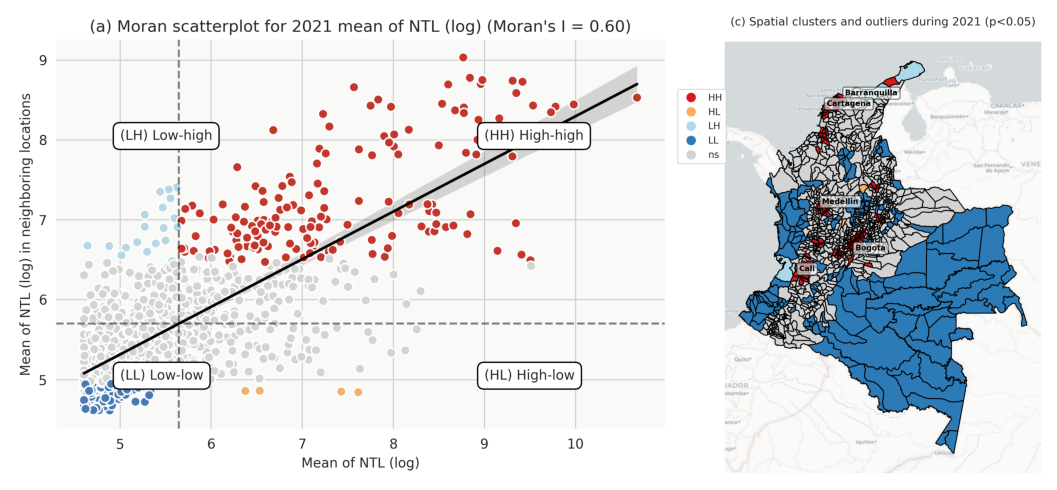

In [ ]:
# Combine figures

# Read the two PNG files
image1 = mpimg.imread('lisaSC2.png')
image2 = mpimg.imread("lisaMAP_NTL_2021.png")

# Create a figure and a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=-0.6)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('lisa2.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

# Combined figures

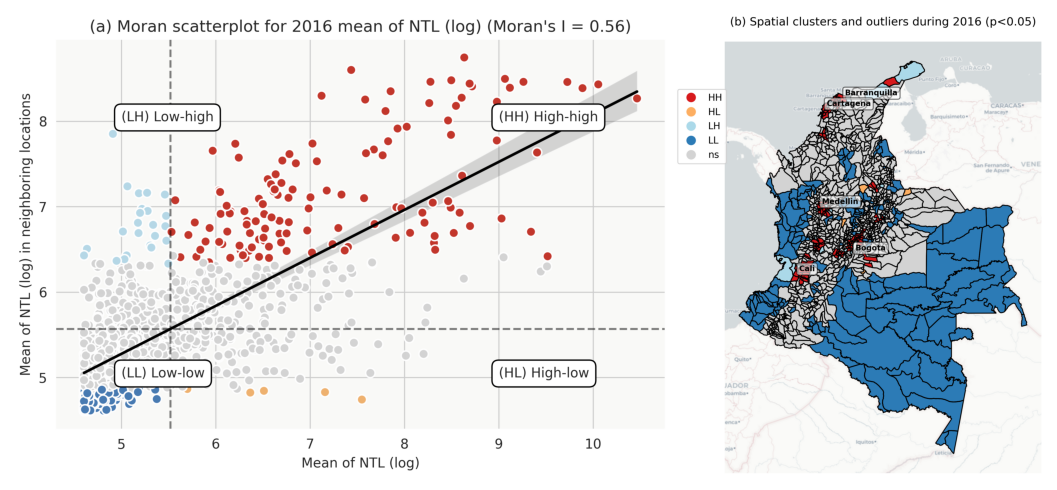

In [ ]:
# Combine figures

# Read the two PNG files
image1 = mpimg.imread('lisaSC.png')
image2 = mpimg.imread("lisaMAP_NTL_2016.png")

# Create a figure and a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=-0.6)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('lisa1.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

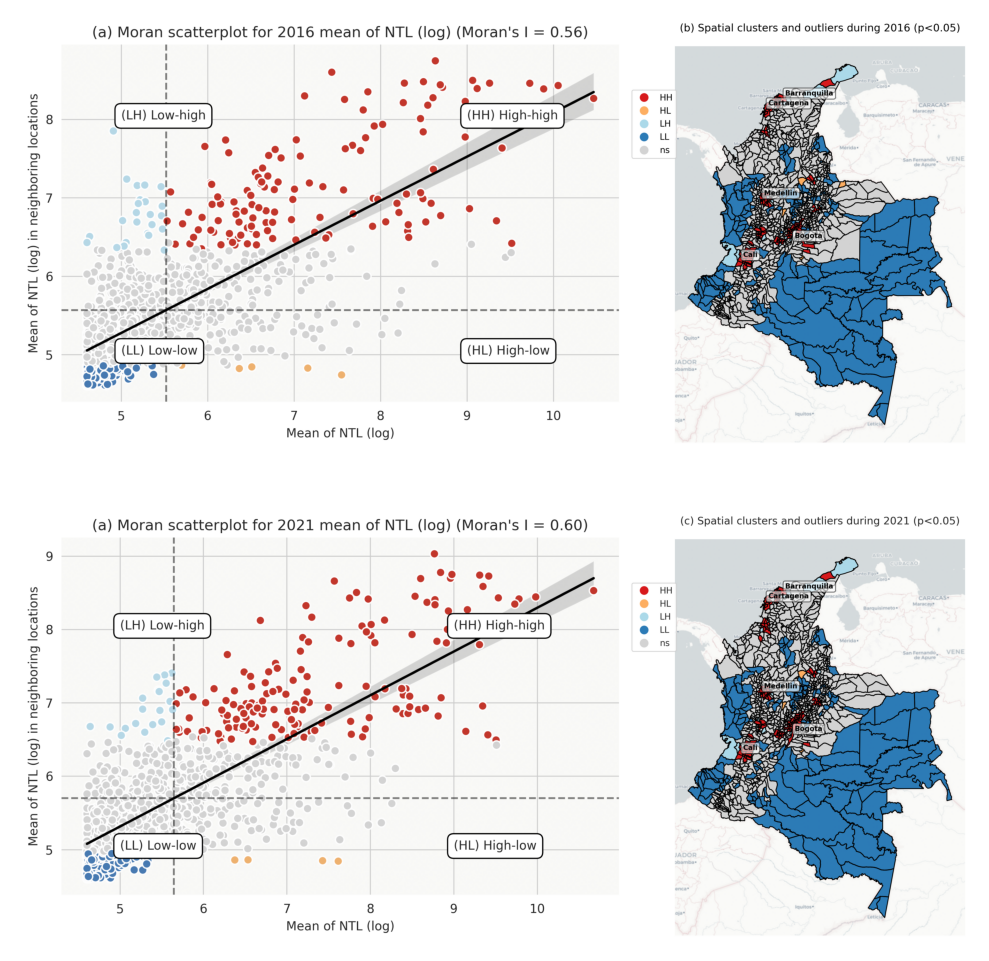

In [ ]:
# Combine figures

# Read the two PNG files
image1 = mpimg.imread('lisa1.png')
image2 = mpimg.imread("lisa2.png")

# Create a figure and a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=-0.6)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('lisa.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

In [ ]:
# @title What happen for the other years

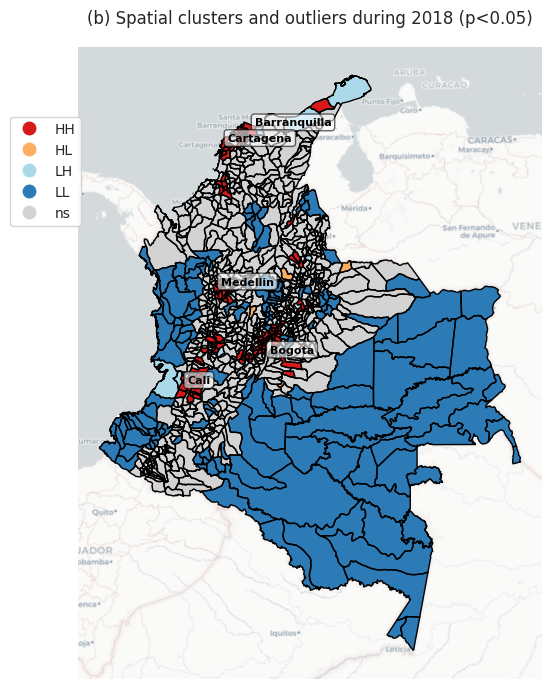

In [ ]:
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2018, gdf, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(b) Spatial clusters and outliers during 2018 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf[gdf['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_NTL_2018.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

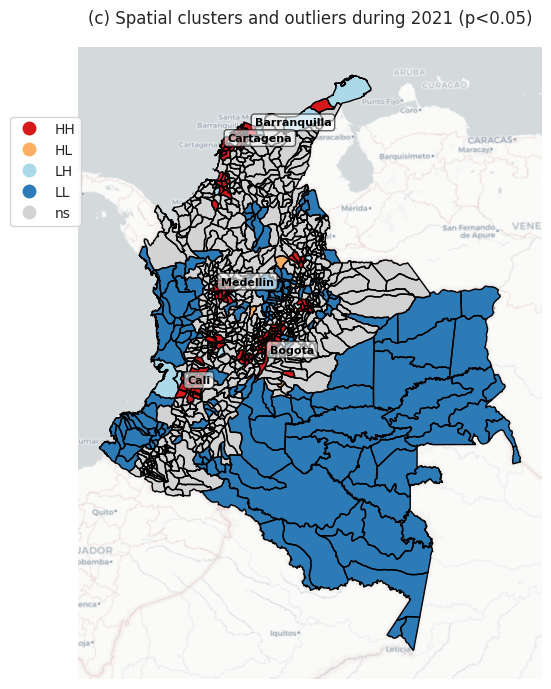

In [ ]:
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2021, gdf, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(c) Spatial clusters and outliers during 2021 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf[gdf['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_NTL_2021.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

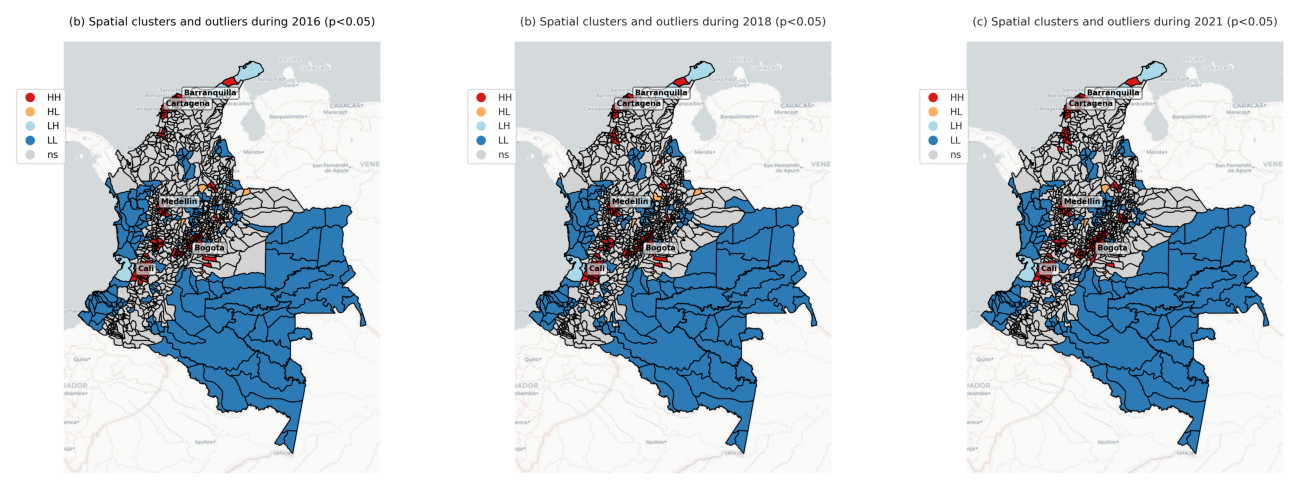

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Leer las imágenes
image1 = mpimg.imread('lisaMAP_NTL_2016.png')
image2 = mpimg.imread('lisaMAP_NTL_2018.png')
image3 = mpimg.imread('lisaMAP_NTL_2021.png')

# Create a figure and a 1x3 grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Display the third image in the third subplot
ax3.imshow(image3)
ax3.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('cluster_comparation.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

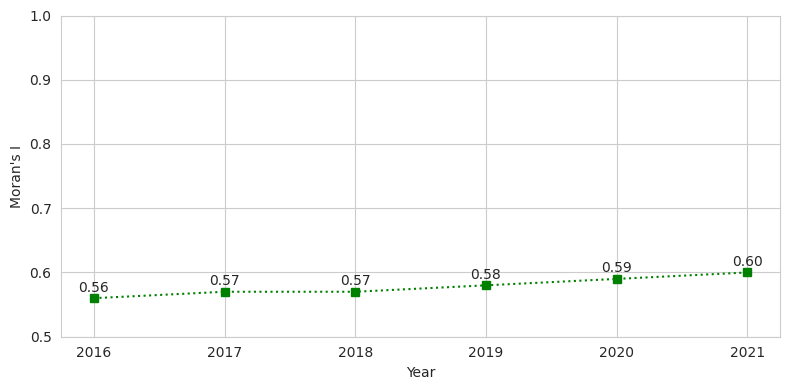

In [ ]:
# Datos
x = [2016, 2017, 2018, 2019, 2020, 2021]
y = [0.56, 0.57, 0.57, 0.58, 0.59, 0.60]

# Crear gráfico de líneas
plt.figure(figsize=(8, 4))
plt.plot(x, y, marker='s', color='green', linestyle=':')


# Etiquetas de los ejes
plt.xlabel("Year")
plt.ylabel("Moran's I")

plt.ylim(0.5, 1)

# Agregar etiquetas a cada punto
for i, value in enumerate(y):
    plt.text(x[i], y[i] + 0.01, f"{value:.2f}", ha='center')


plt.grid(True)
plt.tight_layout()
plt.show()